In [1]:
import numpy as np
from numpy import round
from numpy.linalg import eig
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def PCA(X, k):
    #centering each column by subtracting mean of each column from each data point
    X_centered = X.sub(X.mean())

    #calculating covariance matrix of centered data points
    covariance_matrix = X_centered.cov()

    #calculating eigen values and eigen vectors of the covariance matrix
    evalues, evectors = eig(covariance_matrix)

    #sorting the eigen values in descending order and selecting k largest eigen values
    #and corresponding eigen vectors
    idx = evalues.argsort()[-k:][::-1]
    evalues = evalues[idx]
    evectors = evectors[:,idx]
    
    #projecting the data onto the selected eigen vectors
    X_reduced = X_centered @ evectors

    X_reduced.columns =['PC'+str(_+1) for _ in range(len(X_reduced.columns))]
    
    return X_reduced, evectors

In [3]:
iris_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris_df.columns = ['X1', 'X2', 'X3', 'X4', 'Label']
iris_df.head()

,X1,X2,X3,X4,Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
X = iris_df[iris_df.columns[:-1]]
y = iris_df[iris_df.columns[-1]]

In [5]:
X_reduced_df, evectors = PCA(X, 2)
X_reduced_df.head()

,PC1,PC2
0,-2.684207,-0.326607
1,-2.715391,0.169557
2,-2.889820,0.137346
3,-2.746437,0.311124
4,-2.728593,-0.333925


In [6]:
X_reduced_df.var()

PC1    4.224841
PC2    0.242244
dtype: float64

In [7]:
X_reduced_df.cov()

,PC1,PC2
PC1,4.224841e+00,6.911741e-17
PC2,6.911741e-17,2.422436e-01


In [8]:
for i in X_reduced_df.columns:
    #calculate % of variance for each column
    var = X_reduced_df[i].var() / sum(X_reduced_df.var()) * 100
    print(f"{i} captures about {np.round(var, decimals = 2)} % of the variance.")

PC1 captures about 94.58 % of the variance.
PC2 captures about 5.42 % of the variance.


## Spectral Clustering

In [9]:
def spectral_clustering(X, n_clusters):
    similarity_matrix = np.exp(-squareform(pdist(X,'sqeuclidean')))

    #compute degree matrix
    D = np.diag(np.sum(similarity_matrix, axis = 1))

    #compute laplacian matrix
    L = D - similarity_matrix

    #compute eigenvectors corresponding to the smallest eigenvalues
    _, evectors = eigsh(L, k = n_clusters, which = 'SM')

    #perform KMeans clustering on eigenvectors
    kmeans = KMeans(n_clusters = n_clusters, random_state = 69)
    labels = kmeans.fit_predict(evectors)

    return labels

In [10]:
def label_mapping(y):
    species_names = y.unique()
    label_mapping = {species_names[i]: i for i in range(len(species_names))}
    y_mapped = y.map(label_mapping)

    return y_mapped

In [11]:
y_mapped = label_mapping(y)
X_reduced_with_labels_df = X_reduced_df.copy()
X_reduced_with_labels_df['IntegerLabels'] = y_mapped
X_reduced_with_labels_df.head()

,PC1,PC2,IntegerLabels
0,-2.684207,-0.326607,0
1,-2.715391,0.169557,0
2,-2.889820,0.137346,0
3,-2.746437,0.311124,0
4,-2.728593,-0.333925,0


In [12]:
labels_before_pca = spectral_clustering(X, 3)

labels_after_pca = spectral_clustering(X_reduced_df,3)

accuracy_before_pca = np.sum(labels_before_pca == y_mapped)/len(y_mapped)
print(f'Accuracy before PCA: {accuracy_before_pca * 100} %')

accuracy_after_pca = np.sum(labels_after_pca == y_mapped)/len(y_mapped)
print(f'Accuracy after PCA: {round(accuracy_after_pca* 100, decimals = 2)} %')

Accuracy before PCA: 70.0 %
Accuracy after PCA: 63.33 %


<Axes: xlabel='PC1', ylabel='PC2'>

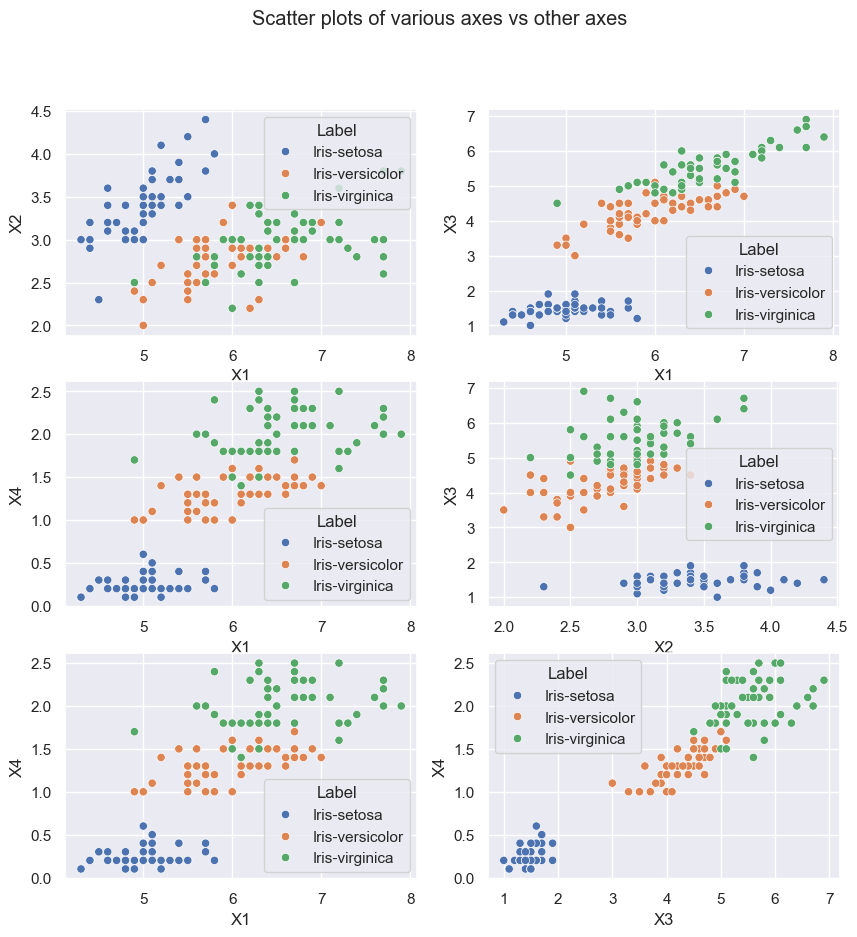

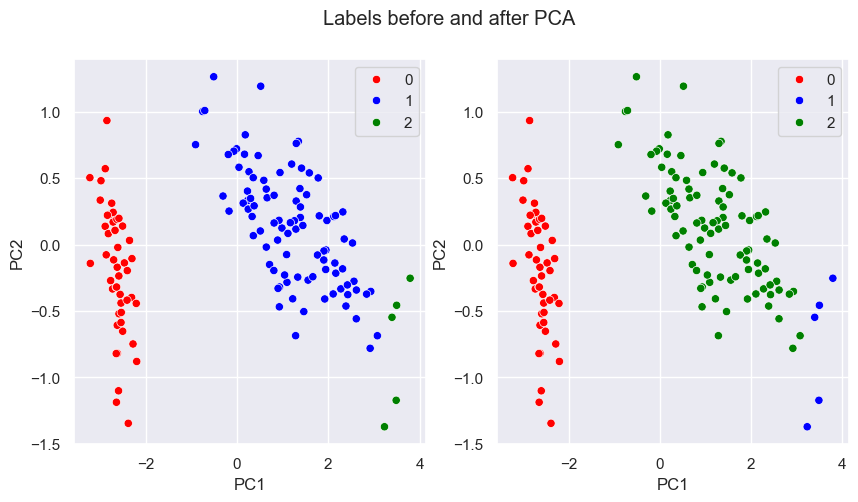

In [13]:
fig2, axes2 = plt.subplots(3,2, figsize = (10,10))
fig2.suptitle('Scatter plots of various axes vs other axes')

sns.scatterplot(ax = axes2[0, 0], x = 'X1', y = 'X2', data = iris_df, hue = 'Label')
sns.scatterplot(ax = axes2[0, 1], x = 'X1', y = 'X3', data = iris_df, hue = 'Label')
sns.scatterplot(ax = axes2[1, 0], x = 'X1', y = 'X4', data = iris_df, hue = 'Label')
sns.scatterplot(ax = axes2[1, 1], x = 'X2', y = 'X3', data = iris_df, hue = 'Label')
sns.scatterplot(ax = axes2[2, 0], x = 'X1', y = 'X4', data = iris_df, hue = 'Label')
sns.scatterplot(ax = axes2[2, 1], x = 'X3', y = 'X4', data = iris_df, hue = 'Label')

fig3, axes3 = plt.subplots(1,2, figsize = (10,5))
fig3.suptitle('Labels before and after PCA')

sns.scatterplot(ax = axes3[0], x = 'PC1', y = 'PC2', data = X_reduced_df, hue = labels_before_pca, palette=['red', 'blue','green'])
sns.scatterplot(ax = axes3[1], x = 'PC1', y = 'PC2', data = X_reduced_df, hue = labels_after_pca, palette=['red', 'blue','green'])
# axes[0].set_title('X1 vs X2')